In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import  KNeighborsClassifier
from imblearn.over_sampling import SMOTE


In [2]:
df=pd.read_csv('diabetes.csv')
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [3]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [4]:
to_drop=df[(df.BMI==0 )|(df.BloodPressure==0)|(df.SkinThickness==99)| (df.Glucose==0)]
df.drop(to_drop.index,inplace=True)

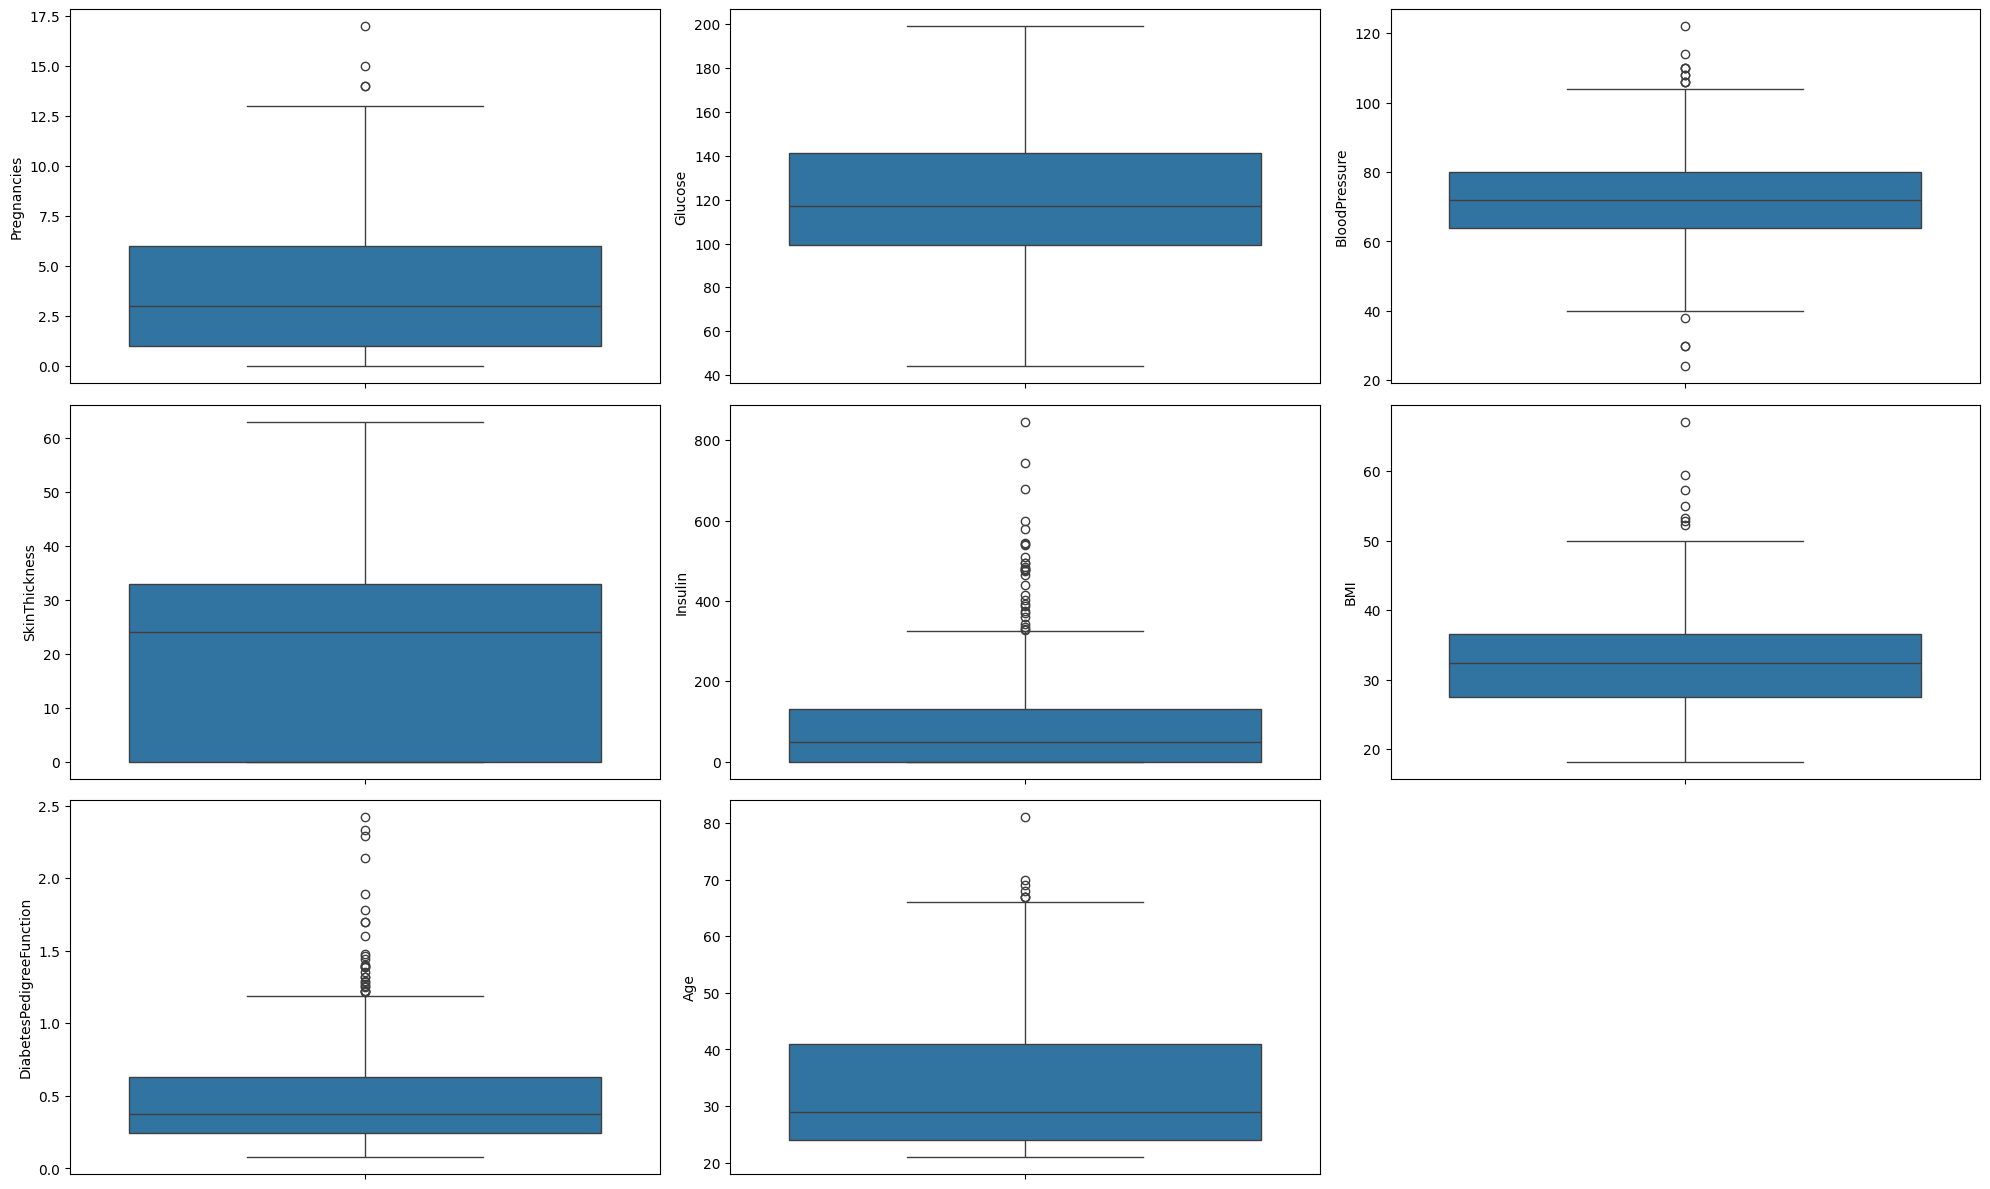

In [5]:
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
            'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
outlier_indices = set()
plt.figure(figsize=(20, 12))
for i, col in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=df, y=col)
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col]=np.where(df[col] < lower_bound,lower_bound,df[col])
    df[col]=np.where(df[col] > upper_bound,upper_bound,df[col])

plt.tight_layout()
plt.show()


In [6]:
df.shape

(723, 9)

In [7]:
df.Outcome.value_counts()

Outcome
0    475
1    248
Name: count, dtype: int64

In [8]:
x=df.iloc[:,:-1]
y=df.iloc[:,-1]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)
x_train.shape

(578, 8)

In [9]:
print(np.unique(y_train,return_counts=True))

(array([0, 1]), array([380, 198]))


In [10]:
smote = SMOTE(random_state=42)
x_train_bal, y_train_bal = smote.fit_resample(x_train, y_train)
print(np.unique(y_train_bal,return_counts=True))

(array([0, 1]), array([380, 380]))


In [11]:
sc=StandardScaler()
x_train_bal_sc=sc.fit_transform(x_train_bal)
x_test_sc=sc.transform(x_test)

In [19]:
from sklearn.model_selection import GridSearchCV
r_num=42
grid_models = [(LogisticRegression(),[{'C':[0.25,0.5,0.75,1],'random_state':[r_num]}]), 
               (KNeighborsClassifier(),[{'n_neighbors':[5,7,9], 'metric': ['euclidean', 'manhattan','minkowski']}]), 
               (SVC(),[{'C':[0.25,0.5,0.75,1],'kernel':['linear', 'rbf'],'gamma':[0.01,0.05],'random_state':[r_num]}]), 
               (RandomForestClassifier(),[{'n_estimators':[100,150],'criterion':['gini','entropy'],'max_depth':[6,9,12],'min_samples_leaf':[20,25,30],'random_state':[r_num]}]),]
for i,j in grid_models:
    grid = GridSearchCV(estimator=i,param_grid = j, scoring='roc_auc',cv = 5)
    grid.fit(x_train_bal_sc, y_train_bal)
    best_accuracy = grid.best_score_
    best_param = grid.best_params_
    print(i,best_accuracy*100)
    print('Best Parameters : ',best_param)
    print('----------------')

LogisticRegression() 85.30470914127423
Best Parameters :  {'C': 0.25, 'random_state': 42}
----------------
KNeighborsClassifier() 86.55470914127423
Best Parameters :  {'metric': 'manhattan', 'n_neighbors': 7}
----------------
SVC() 86.95637119113572
Best Parameters :  {'C': 1, 'gamma': 0.05, 'kernel': 'rbf', 'random_state': 42}
----------------
RandomForestClassifier() 87.84279778393352
Best Parameters :  {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 20, 'n_estimators': 100, 'random_state': 42}
----------------


In [20]:
rf=RandomForestClassifier(max_depth=9,min_samples_leaf=20,n_estimators=100,criterion='entropy',random_state=42)
rf.fit(x_train_bal,y_train_bal)
y_prob_rf = rf.predict_proba(x_test)[:, 1]
rf.score(x_train_bal,y_train_bal),rf.score(x_test,y_test)

(0.8657894736842106, 0.7379310344827587)